In [1]:
import torch
import datetime
import torchvision
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import requests
import tarfile
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset
import zipfile
from PIL import Image, ImageEnhance
import torchvision.transforms.functional as TF
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(4)
import torchvision.transforms as T
import matplotlib.pyplot as plt
from tqdm import tqdm
t2img = T.ToPILImage()
img2t = T.ToTensor()

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
folder_path = "/content/drive/My Drive/ADL"

Mounted at /content/drive


In [3]:
# Assuming folder_path is already set to the current working directory
with zipfile.ZipFile(f"{folder_path}/pets_images_final.zip", 'r') as zip_ref:
    zip_ref.extractall("/sample_data")
pretrain_data_path = '/sample_data/pets_images'

In [4]:
# List everything in /tmp
tmp_contents = os.listdir(pretrain_data_path)
print(tmp_contents)

['image_35119.jpg', 'image_19697.jpg', 'image_7195.jpg', 'image_11603.jpg', 'image_15590.jpg', 'image_22149.jpg', 'image_16887.jpg', 'image_9334.jpg', 'image_33334.jpg', 'image_24372.jpg', 'image_8174.jpg', 'image_9108.jpg', 'image_6085.jpg', 'image_27406.jpg', 'image_24206.jpg', 'image_12332.jpg', 'image_17708.jpg', 'image_18296.jpg', 'image_21856.jpg', 'image_21700.jpg', 'image_28408.jpg', 'image_881.jpg', 'image_3981.jpg', 'image_34182.jpg', 'image_34111.jpg', 'image_9082.jpg', 'image_36609.jpg', 'image_26998.jpg', 'image_15522.jpg', 'image_3804.jpg', 'image_857.jpg', 'image_17490.jpg', 'image_17484.jpg', 'image_36599.jpg', 'image_9706.jpg', 'image_6037.jpg', 'image_35883.jpg', 'image_17693.jpg', 'image_35722.jpg', 'image_19356.jpg', 'image_14306.jpg', 'image_34913.jpg', 'image_11458.jpg', 'image_24636.jpg', 'image_3485.jpg', 'image_22225.jpg', 'image_30426.jpg', 'image_29604.jpg', 'image_14443.jpg', 'image_14957.jpg', 'image_27528.jpg', 'image_18858.jpg', 'image_7802.jpg', 'image_2

In [5]:
num_workers = os.cpu_count()
num_workers

8

In [6]:
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # normalize to [-1, 1]
    transforms.Lambda(lambda x: x / 2 + 0.5),  # normalize to [0, 1]
])

def greyscale(image):
    grayscale_transform = transforms.RandomGrayscale(p=0.2)
    imgs = []
    for i in range(image.shape[0]):
        im=transforms.ToPILImage()(image[i])
        greyscale_image = grayscale_transform(im)
        imgs.append(transform(greyscale_image).unsqueeze(0))

    return torch.cat(imgs,0)

def distort_color(image):
    color_jitter = transforms.ColorJitter(
        brightness=0.5,
        contrast=0.5,
        saturation=0.5,
        hue=0.1
    )
    imgs=[]
    for i in range(image.shape[0]):
        im=transforms.ToPILImage()(image[i])
        distorted_image = color_jitter(im)
        imgs.append(transform(distorted_image).unsqueeze(0))
    return torch.cat(imgs,0)

def mask_image(image, low_mask_percentage,high_mask_percentage):
    for i in range(image.shape[0]):
        mask_percentage=random.randint(low_mask_percentage,high_mask_percentage)
        rows, cols = image.shape[2:]
        rows_to_mask = int(rows * mask_percentage / 100)
        cols_to_mask = int(cols * mask_percentage / 100)

        top_left_row = random.randint(0, rows - rows_to_mask)
        top_left_col = random.randint(0, cols - cols_to_mask)

        image[i,:, top_left_row:top_left_row + rows_to_mask, top_left_col:top_left_col + cols_to_mask] = 0.5

    return image

distort=transforms.Compose([
    transforms.RandomChoice([lambda x: mask_image(x,5,25),greyscale,distort_color]),
])

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


In [8]:
class CustomImageDataset(Dataset):
    """A custom dataset class for loading preprocessed and saved images."""

    def __init__(self, image_dir, transform=None):
        """
        Args:
            image_dir (string): Path to the directory with preprocessed images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = [os.path.join(image_dir, img_name) for img_name in os.listdir(image_dir)
                            if os.path.isfile(os.path.join(image_dir, img_name))]

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to be fetched

        Returns:
            A tuple (image, label), where 'image' is the transformed image tensor,
            and 'label' could be a dummy value if not applicable.
        """
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Convert to RGB for consistency

        if self.transform:
            image = self.transform(image)

        label = 0
        return image



In [9]:
pre_training_data= CustomImageDataset(pretrain_data_path,transform=transform)
pre_train_dataloader = DataLoader(pre_training_data, batch_size=64, shuffle=True)
len(pre_train_dataloader)

579

In [11]:
class DC2(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
            nn.Conv2d(in_channels=output_channel, out_channels=output_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
        )
        self.max_pool = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        y = self.seq(x)
        y_shape = y.shape
        y, index = self.max_pool (y)
        return y, index, y_shape

class DC3(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
            nn.Conv2d(in_channels=output_channel, out_channels=output_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
            nn.Conv2d(in_channels=output_channel, out_channels=output_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
        )
        self.max_pool  = nn.MaxPool2d(kernel_size=2, return_indices=True)

    def forward(self, x):
        y = self.seq(x)
        y_shape = y.shape
        y, index = self.max_pool(y)
        return y, index, y_shape

class UC2(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=input_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU(),
            nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
        )
        self.max_unpool = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, index, output_size):
        y = self.max_unpool(x, index, output_size=output_size)
        y = self.seq(y)
        return y

class UC3(nn.Module):
    def __init__(self, input_channel, output_channel, kernel_size):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=input_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU(),
            nn.Conv2d(in_channels=input_channel, out_channels=input_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU(),
            nn.Conv2d(in_channels=input_channel, out_channels=output_channel, kernel_size=kernel_size, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(),
        )
        self.max_unpool = nn.MaxUnpool2d(kernel_size=2)

    def forward(self, x, index, output_size):
        y = self.max_unpool(x, index, output_size=output_size)
        y = self.seq(y)
        return y


class Segnet(torch.nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.out_channels = 3
        self.batch_norm_input = nn.BatchNorm2d(3)
        self.dc_1 = DC2(3, 64, kernel_size=kernel_size)
        self.dc_2 = DC2(64, 128, kernel_size=kernel_size)
        self.dc_3 = DC3(128, 256, kernel_size=kernel_size)
        self.dc_4 = DC3(256, 512, kernel_size=kernel_size)


        self.uc_4 = UC3(512, 256, kernel_size=kernel_size)
        self.uc_3 = UC3(256, 128, kernel_size=kernel_size)
        self.uc_2 = UC2(128, 64, kernel_size=kernel_size)
        self.uc_1 = UC2(64, 3, kernel_size=kernel_size)

    def forward(self, batch: torch.Tensor):
        x = self.batch_norm_input(batch)

        # SegNet Encoder
        x, max_pool_1_index, s1 = self.dc_1(x)
        x, max_pool_2_index, s2 = self.dc_2(x)
        x, max_pool_3_index, s3 = self.dc_3(x)
        x, max_pool_4_index, s4 = self.dc_4(x)


        # SegNet Decoder

        x = self.uc_4(x, max_pool_4_index, output_size=s4)
        x = self.uc_3(x, max_pool_3_index, output_size=s3)
        x = self.uc_2(x, max_pool_2_index, output_size=s2)
        x = self.uc_1(x, max_pool_1_index, output_size=s1)

        return x

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


In [13]:
model = Segnet().to(device)
criterion1 =  torch.nn.MSELoss().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

In [14]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
batch_norm_input.weight 	 torch.Size([3])
batch_norm_input.bias 	 torch.Size([3])
batch_norm_input.running_mean 	 torch.Size([3])
batch_norm_input.running_var 	 torch.Size([3])
batch_norm_input.num_batches_tracked 	 torch.Size([])
dc_1.seq.0.weight 	 torch.Size([64, 3, 3, 3])
dc_1.seq.1.weight 	 torch.Size([64])
dc_1.seq.1.bias 	 torch.Size([64])
dc_1.seq.1.running_mean 	 torch.Size([64])
dc_1.seq.1.running_var 	 torch.Size([64])
dc_1.seq.1.num_batches_tracked 	 torch.Size([])
dc_1.seq.3.weight 	 torch.Size([64, 64, 3, 3])
dc_1.seq.4.weight 	 torch.Size([64])
dc_1.seq.4.bias 	 torch.Size([64])
dc_1.seq.4.running_mean 	 torch.Size([64])
dc_1.seq.4.running_var 	 torch.Size([64])
dc_1.seq.4.num_batches_tracked 	 torch.Size([])
dc_2.seq.0.weight 	 torch.Size([128, 64, 3, 3])
dc_2.seq.1.weight 	 torch.Size([128])
dc_2.seq.1.bias 	 torch.Size([128])
dc_2.seq.1.running_mean 	 torch.Size([128])
dc_2.seq.1.running_var 	 torch.Size([128])
dc_2.seq.1.num_batches_tracked 	 torc

In [15]:
def calculate_supervised_dice_score(predictions, ground_truth):
    """
    Calculate the supervised Dice loss for labeled data.

    Args:
        predictions (torch.Tensor): Predictions for labeled data, with shape (batch_size, num_classes, height, width).
        ground_truth (torch.Tensor): Ground truth masks for labeled data, with shape (batch_size, num_classes, height, width).

    Returns:
        torch.Tensor: Supervised Dice loss.
    """


    #predictions = nn.Softmax(dim=1)(predictions)

    #ground_truth = torch.cat([ (ground_truth == i) for i in range(3) ], dim=1)


    #intersection = ground_truth * predictions
    #union = ground_truth + predictions
    #iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)
    # Convert raw model outputs into probabilities within the range [0, 1] to ensure alignment with the ground truth masks
    predictions = torch.sigmoid(predictions)

    # Smoothing factor to prevent division by zero
    smooth = 1e-5


    # Compute the intersection and union
    intersection = torch.sum(ground_truth * predictions, dim=(1,2,3))
    union = torch.sum(ground_truth+ predictions, dim=(1, 2, 3)) #+ torch.sum(predictions, dim=(1, 2, 3))

    # Calculate the Dice loss
    dice_score = 2 * (intersection + smooth) / (union + smooth)
    return dice_score.sum()

In [16]:
def pretrain(net, criterion, optimizer, trainloader, epochs):
    trainloss=[]
    net.train().to(device)
    dl=[]
    for epoch in range(epochs):
        print('Epoch', epoch+1)
        running_loss = 0.0
        dice=0.0
        total=0.0
        for i, data in tqdm(enumerate(trainloader, 0)):
            optimizer.zero_grad()
            inputs = data.to(device)
            inputs_distorted=distort(inputs).float().to(device)
            outputs = net(inputs_distorted)
            loss = criterion(outputs, inputs)
            loss.backward(retain_graph=False)
            dice+=calculate_supervised_dice_score(outputs,inputs).item()
            optimizer.step()
            running_loss += loss.detach().item()
            total += inputs.size(0)
        trainloss.append(running_loss/total)
        dl.append(dice/total)
        print('[%d, %2d]  MSE loss: %.5f Dice Score: %.5f'  %
                    (epoch + 1,epochs, trainloss[epoch],dl[epoch] ))
    return trainloss , dl

In [17]:
mse , dlpt = pretrain(model, criterion1, optimizer, pre_train_dataloader, 20)

Epoch 1


579it [03:09,  3.05it/s]


[1, 20]  MSE loss: 0.00053 Dice Score: 0.52254
Epoch 2


579it [03:12,  3.01it/s]


[2, 20]  MSE loss: 0.00020 Dice Score: 0.52807
Epoch 3


579it [03:14,  2.98it/s]


[3, 20]  MSE loss: 0.00015 Dice Score: 0.52917
Epoch 4


579it [03:12,  3.00it/s]


[4, 20]  MSE loss: 0.00012 Dice Score: 0.52983
Epoch 5


579it [03:09,  3.05it/s]


[5, 20]  MSE loss: 0.00010 Dice Score: 0.53029
Epoch 6


579it [03:11,  3.02it/s]


[6, 20]  MSE loss: 0.00009 Dice Score: 0.53046
Epoch 7


579it [03:16,  2.94it/s]


[7, 20]  MSE loss: 0.00009 Dice Score: 0.53055
Epoch 8


579it [03:09,  3.06it/s]


[8, 20]  MSE loss: 0.00007 Dice Score: 0.53078
Epoch 9


579it [03:13,  3.00it/s]


[9, 20]  MSE loss: 0.00007 Dice Score: 0.53081
Epoch 10


579it [03:14,  2.98it/s]


[10, 20]  MSE loss: 0.00007 Dice Score: 0.53087
Epoch 11


579it [03:14,  2.97it/s]


[11, 20]  MSE loss: 0.00007 Dice Score: 0.53084
Epoch 12


579it [03:10,  3.04it/s]


[12, 20]  MSE loss: 0.00006 Dice Score: 0.53110
Epoch 13


579it [03:11,  3.02it/s]


[13, 20]  MSE loss: 0.00007 Dice Score: 0.53081
Epoch 14


579it [03:12,  3.00it/s]


[14, 20]  MSE loss: 0.00006 Dice Score: 0.53108
Epoch 15


579it [03:15,  2.96it/s]


[15, 20]  MSE loss: 0.00006 Dice Score: 0.53093
Epoch 16


579it [03:13,  2.99it/s]


[16, 20]  MSE loss: 0.00005 Dice Score: 0.53107
Epoch 17


579it [03:13,  3.00it/s]


[17, 20]  MSE loss: 0.00005 Dice Score: 0.53114
Epoch 18


579it [03:12,  3.01it/s]


[18, 20]  MSE loss: 0.00005 Dice Score: 0.53112
Epoch 19


579it [03:14,  2.98it/s]


[19, 20]  MSE loss: 0.00005 Dice Score: 0.53113
Epoch 20


579it [03:11,  3.03it/s]

[20, 20]  MSE loss: 0.00005 Dice Score: 0.53108


In [18]:
model_path = os.path.join(folder_path, f'segnet_pretrained.pt')
torch.save(model.state_dict(), model_path)

In [19]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Streaming output truncated to the last 5000 lines.
         1.8667e-06, -1.6876e-06,  4.4094e-07, -5.9764e-07,  7.0508e-07,
        -3.0882e-07, -1.4801e-06,  5.5831e-07, -4.4082e-07,  1.1736e-06,
        -1.7925e-07,  6.1041e-07,  1.2950e-06,  5.6991e-07, -2.9921e-07,
        -1.4458e-07, -2.0571e-08,  4.7857e-07, -2.3509e-07,  2.1707e-07,
         4.1330e-07,  2.8398e-06,  1.1832e-06, -5.2669e-06, -6.9506e-07,
        -1.3731e-06,  1.0649e-06,  2.4399e-06, -4.1998e-06, -3.8175e-07,
        -1.2170e-06, -3.8481e-07, -2.2215e-07, -1.0510e-06, -3.9543e-08,
         5.4016e-07,  1.1256e-06,  4.0446e-07,  1.1920e-06,  2.5215e-08,
        -3.4551e-07,  2.6116e-07,  8.2971e-07, -1.2071e-06, -2.1368e-07,
         2.1541e-07, -6.4491e-07, -5.9260e-07, -2.2102e-06, -2.3396e-06,
         5.2687e-07, -7.0429e-07,  2.4685e-06,  4.6396e-07,  1.7743e-07,
         1.0573e-06,  5.0342e-07, -9.2747e-07,  2.5029e-06, -1.7415e-06,
        -2.1997e-06,  7.0093e-06,  1.7225e-08, -1.2516e-06, -3.8815e-07,


In [20]:
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

In [21]:

transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # normalize to [-1, 1]
    transforms.Lambda(lambda x: x / 2 + 0.5),  # normalize to [0, 1]
])
target_transform=transforms.Compose([
    transforms.Resize((120, 120),interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),T.Lambda(tensor_trimap)
    #transforms.Lambda(lambda x: torch.nn.functional.one_hot((x*255).long() - 1,3).squeeze(0).permute(2,0,1))
])



training_data = torchvision.datasets.OxfordIIITPet(root='./data/oxford-pets', split='trainval',transform=transform,target_types="segmentation",target_transform=target_transform,download=True)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True,num_workers=num_workers)




testing_data = torchvision.datasets.OxfordIIITPet(root='./data/oxford-pets', split='test',transform=transform,target_types="segmentation",target_transform=target_transform,download=True)
test_dataloader = DataLoader(testing_data, batch_size=3, shuffle=False,num_workers=num_workers)

100%|██████████| 791918971/791918971 [00:08<00:00, 88672148.53it/s]


Extracting data/oxford-pets/oxford-iiit-pet/images.tar.gz to data/oxford-pets/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 66956679.87it/s]


Extracting data/oxford-pets/oxford-iiit-pet/annotations.tar.gz to data/oxford-pets/oxford-iiit-pet


NameError: name 'testing_data' is not defined

In [22]:
(train_pets_inputs, train_pets_targets) = next(iter(train_dataloader))

train_pets_inputs.shape, train_pets_targets.shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([64, 3, 120, 120]), torch.Size([64, 1, 120, 120]))

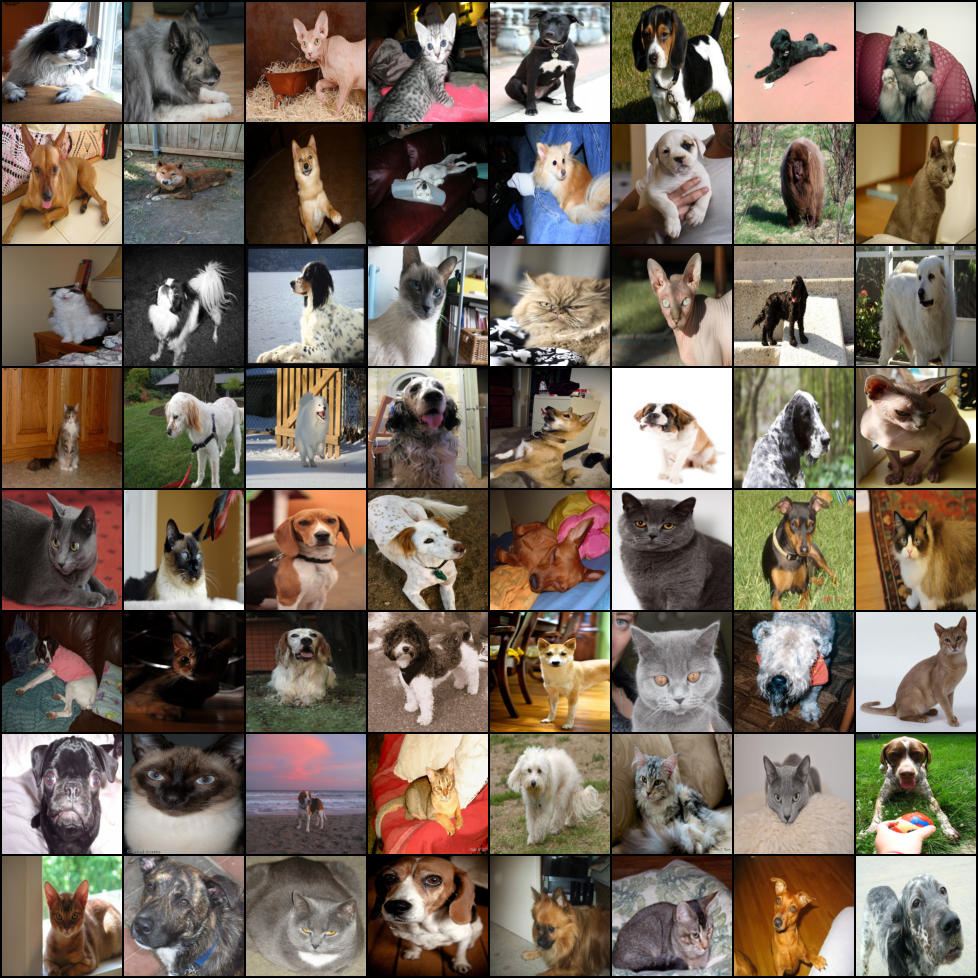

In [23]:
pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
t2img(pets_input_grid)

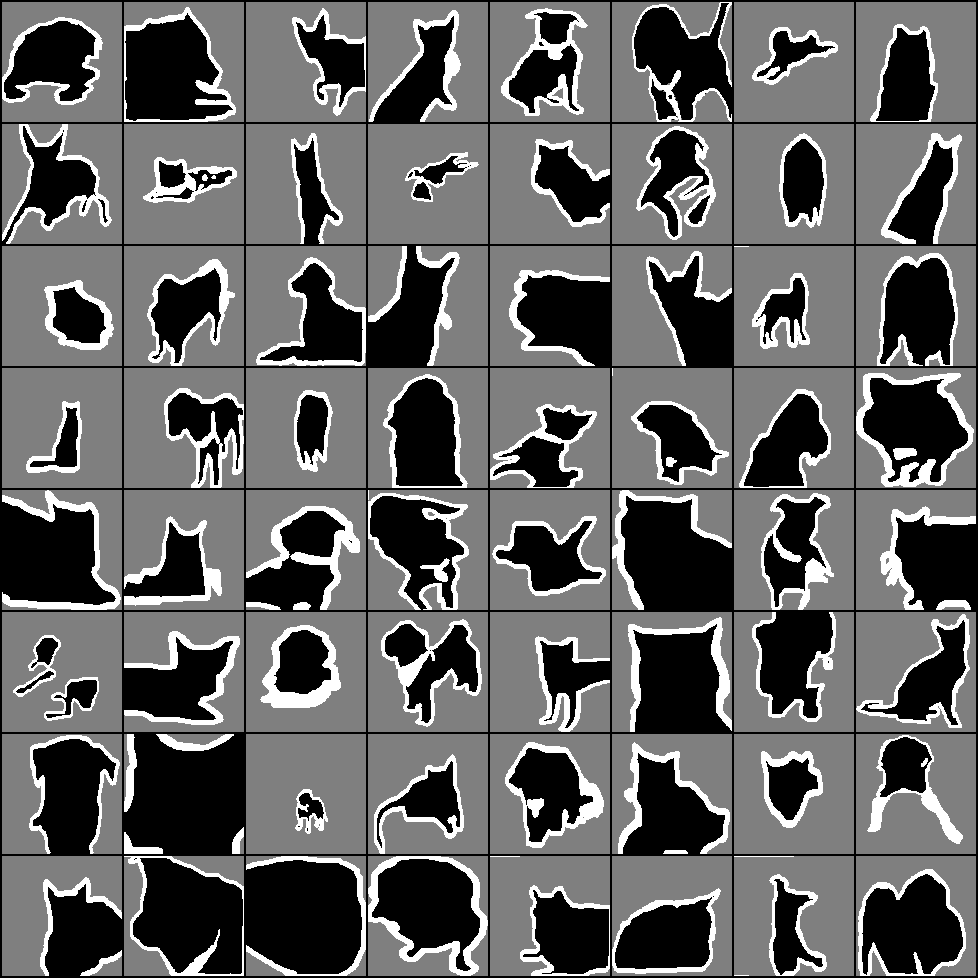

In [24]:
pets_targets_grid = torchvision.utils.make_grid(train_pets_targets/2.0  , nrow=8)
t2img(pets_targets_grid)

In [26]:
def IOU_metric(prediction, ground_truth):

    prediction = nn.Softmax(dim=1)(prediction)

    ground_truth = torch.cat([ (ground_truth == i) for i in range(3) ], dim=1)


    intersection = ground_truth * prediction
    union = ground_truth + prediction - intersection
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)

    return iou.mean()

class IOU_Loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, prediction, ground_truth):

        return -(IOU_metric(prediction, ground_truth).log())


In [28]:
criterion2 =  IOU_Loss().to(device)

In [29]:
def train(net, criterion, optimizer, trainloader, epochs):
    trainloss=[]
    dl=[]
    net.train().to(device)
    for epoch in range(epochs):

        print('Epoch', epoch+1)
        running_loss = 0.0
        dice=0.0
        total=0.0
        for  batch_idx, data in tqdm(enumerate(trainloader, 0)):
            optimizer.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.float().to(device), labels.float().to(device)
            outputs = net(inputs)

            #print(labels.shape,inputs.shape,outputs.shape)
            #labels = labels.squeeze(dim=1)
            loss = criterion(outputs, labels)
            #loss = criterion(outputs, labels)


            loss.backward(retain_graph=False)
            dice+=calculate_supervised_dice_score(outputs,labels).item()
            optimizer.step()
            running_loss += loss.detach().item()
            total += inputs.size(0)
        dl.append(dice/total)
        trainloss.append(running_loss/total)
        print('[%d, %2d]  IOU loss: %.5f Dice Score: %.5f'  %
                    (epoch + 1,epochs, trainloss[epoch],dl[epoch] ))

    return trainloss , dl

In [30]:
tl , dl = train(model, criterion2, optimizer, train_dataloader, 100)

Epoch 1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
58it [00:10,  5.34it/s]

[1, 100]  IOU loss: 0.01604 Dice Score: 0.68483
Epoch 2



58it [00:10,  5.40it/s]

[2, 100]  IOU loss: 0.01270 Dice Score: 0.68497
Epoch 3



58it [00:10,  5.38it/s]

[3, 100]  IOU loss: 0.01202 Dice Score: 0.68593
Epoch 4



58it [00:10,  5.38it/s]

[4, 100]  IOU loss: 0.01157 Dice Score: 0.68680
Epoch 5



58it [00:10,  5.43it/s]

[5, 100]  IOU loss: 0.01125 Dice Score: 0.68778
Epoch 6



58it [00:10,  5.43it/s]

[6, 100]  IOU loss: 0.01098 Dice Score: 0.68849
Epoch 7



58it [00:10,  5.37it/s]

[7, 100]  IOU loss: 0.01079 Dice Score: 0.68922
Epoch 8



58it [00:10,  5.39it/s]

[8, 100]  IOU loss: 0.01050 Dice Score: 0.68979
Epoch 9



58it [00:10,  5.35it/s]

[9, 100]  IOU loss: 0.01028 Dice Score: 0.69080
Epoch 10



58it [00:10,  5.32it/s]

[10, 100]  IOU loss: 0.01004 Dice Score: 0.69134
Epoch 11



58it [00:10,  5.39it/s]

[11, 100]  IOU loss: 0.00988 Dice Score: 0.69213
Epoch 12



58it [00:10,  5.34it/s]

[12, 100]  IOU loss: 0.00970 Dice Score: 0.69258
Epoch 13



58it [00:10,  5.40it/s]

[13, 100]  IOU loss: 0.00954 Dice Score: 0.69330
Epoch 14



58it [00:10,  5.40it/s]

[14, 100]  IOU loss: 0.00946 Dice Score: 0.69382
Epoch 15



58it [00:10,  5.41it/s]

[15, 100]  IOU loss: 0.00926 Dice Score: 0.69434
Epoch 16



58it [00:10,  5.35it/s]

[16, 100]  IOU loss: 0.00912 Dice Score: 0.69486
Epoch 17



58it [00:10,  5.36it/s]

[17, 100]  IOU loss: 0.00896 Dice Score: 0.69547
Epoch 18



58it [00:10,  5.33it/s]

[18, 100]  IOU loss: 0.00883 Dice Score: 0.69590
Epoch 19



58it [00:10,  5.41it/s]

[19, 100]  IOU loss: 0.00868 Dice Score: 0.69642
Epoch 20



58it [00:10,  5.38it/s]

[20, 100]  IOU loss: 0.00856 Dice Score: 0.69691
Epoch 21



58it [00:10,  5.39it/s]

[21, 100]  IOU loss: 0.00848 Dice Score: 0.69733
Epoch 22



58it [00:10,  5.42it/s]

[22, 100]  IOU loss: 0.00837 Dice Score: 0.69772
Epoch 23



58it [00:10,  5.40it/s]

[23, 100]  IOU loss: 0.00822 Dice Score: 0.69825
Epoch 24



58it [00:10,  5.40it/s]

[24, 100]  IOU loss: 0.00814 Dice Score: 0.69862
Epoch 25



58it [00:10,  5.37it/s]

[25, 100]  IOU loss: 0.00801 Dice Score: 0.69896
Epoch 26



58it [00:10,  5.34it/s]

[26, 100]  IOU loss: 0.00789 Dice Score: 0.69945
Epoch 27



58it [00:10,  5.42it/s]

[27, 100]  IOU loss: 0.00781 Dice Score: 0.69974
Epoch 28



58it [00:10,  5.39it/s]

[28, 100]  IOU loss: 0.00770 Dice Score: 0.70010
Epoch 29



58it [00:10,  5.36it/s]

[29, 100]  IOU loss: 0.00764 Dice Score: 0.70043
Epoch 30



58it [00:10,  5.34it/s]

[30, 100]  IOU loss: 0.00752 Dice Score: 0.70072
Epoch 31



58it [00:10,  5.42it/s]

[31, 100]  IOU loss: 0.00740 Dice Score: 0.70108
Epoch 32



58it [00:10,  5.41it/s]

[32, 100]  IOU loss: 0.00731 Dice Score: 0.70141
Epoch 33



58it [00:10,  5.40it/s]

[33, 100]  IOU loss: 0.00724 Dice Score: 0.70164
Epoch 34



58it [00:10,  5.36it/s]

[34, 100]  IOU loss: 0.00715 Dice Score: 0.70198
Epoch 35



58it [00:10,  5.35it/s]

[35, 100]  IOU loss: 0.00706 Dice Score: 0.70222
Epoch 36



58it [00:10,  5.39it/s]

[36, 100]  IOU loss: 0.00697 Dice Score: 0.70253
Epoch 37



58it [00:10,  5.38it/s]

[37, 100]  IOU loss: 0.00689 Dice Score: 0.70278
Epoch 38



58it [00:10,  5.40it/s]

[38, 100]  IOU loss: 0.00681 Dice Score: 0.70304
Epoch 39



58it [00:10,  5.43it/s]

[39, 100]  IOU loss: 0.00675 Dice Score: 0.70329
Epoch 40



58it [00:10,  5.42it/s]

[40, 100]  IOU loss: 0.00668 Dice Score: 0.70353
Epoch 41



58it [00:10,  5.42it/s]

[41, 100]  IOU loss: 0.00658 Dice Score: 0.70379
Epoch 42



58it [00:10,  5.43it/s]

[42, 100]  IOU loss: 0.00651 Dice Score: 0.70405
Epoch 43



58it [00:10,  5.38it/s]

[43, 100]  IOU loss: 0.00645 Dice Score: 0.70423
Epoch 44



58it [00:10,  5.39it/s]

[44, 100]  IOU loss: 0.00638 Dice Score: 0.70447
Epoch 45



58it [00:10,  5.35it/s]

[45, 100]  IOU loss: 0.00634 Dice Score: 0.70469
Epoch 46



58it [00:10,  5.36it/s]

[46, 100]  IOU loss: 0.00626 Dice Score: 0.70496
Epoch 47



58it [00:10,  5.37it/s]

[47, 100]  IOU loss: 0.00618 Dice Score: 0.70515
Epoch 48



58it [00:10,  5.39it/s]

[48, 100]  IOU loss: 0.00611 Dice Score: 0.70538
Epoch 49



58it [00:10,  5.38it/s]

[49, 100]  IOU loss: 0.00608 Dice Score: 0.70555
Epoch 50



58it [00:10,  5.40it/s]

[50, 100]  IOU loss: 0.00602 Dice Score: 0.70578
Epoch 51



58it [00:10,  5.40it/s]

[51, 100]  IOU loss: 0.00597 Dice Score: 0.70595
Epoch 52



58it [00:10,  5.33it/s]

[52, 100]  IOU loss: 0.00589 Dice Score: 0.70617
Epoch 53



58it [00:10,  5.36it/s]

[53, 100]  IOU loss: 0.00582 Dice Score: 0.70638
Epoch 54



58it [00:10,  5.36it/s]

[54, 100]  IOU loss: 0.00577 Dice Score: 0.70659
Epoch 55



58it [00:10,  5.38it/s]

[55, 100]  IOU loss: 0.00572 Dice Score: 0.70676
Epoch 56



58it [00:10,  5.43it/s]

[56, 100]  IOU loss: 0.00566 Dice Score: 0.70696
Epoch 57



58it [00:10,  5.39it/s]

[57, 100]  IOU loss: 0.00562 Dice Score: 0.70715
Epoch 58



58it [00:10,  5.42it/s]

[58, 100]  IOU loss: 0.00556 Dice Score: 0.70732
Epoch 59



58it [00:10,  5.45it/s]

[59, 100]  IOU loss: 0.00551 Dice Score: 0.70750
Epoch 60



58it [00:10,  5.37it/s]

[60, 100]  IOU loss: 0.00544 Dice Score: 0.70767
Epoch 61



58it [00:10,  5.40it/s]

[61, 100]  IOU loss: 0.00540 Dice Score: 0.70788
Epoch 62



58it [00:10,  5.38it/s]

[62, 100]  IOU loss: 0.00536 Dice Score: 0.70803
Epoch 63



58it [00:10,  5.37it/s]

[63, 100]  IOU loss: 0.00532 Dice Score: 0.70822
Epoch 64



58it [00:10,  5.42it/s]

[64, 100]  IOU loss: 0.00529 Dice Score: 0.70837
Epoch 65



58it [00:10,  5.36it/s]

[65, 100]  IOU loss: 0.00521 Dice Score: 0.70854
Epoch 66



58it [00:10,  5.38it/s]

[66, 100]  IOU loss: 0.00518 Dice Score: 0.70872
Epoch 67



58it [00:10,  5.43it/s]

[67, 100]  IOU loss: 0.00513 Dice Score: 0.70891
Epoch 68



58it [00:10,  5.38it/s]

[68, 100]  IOU loss: 0.00508 Dice Score: 0.70901
Epoch 69



58it [00:10,  5.36it/s]

[69, 100]  IOU loss: 0.00503 Dice Score: 0.70918
Epoch 70



58it [00:10,  5.43it/s]

[70, 100]  IOU loss: 0.00498 Dice Score: 0.70936
Epoch 71



58it [00:10,  5.41it/s]

[71, 100]  IOU loss: 0.00496 Dice Score: 0.70958
Epoch 72



58it [00:10,  5.39it/s]

[72, 100]  IOU loss: 0.00490 Dice Score: 0.70963
Epoch 73



58it [00:10,  5.34it/s]

[73, 100]  IOU loss: 0.00487 Dice Score: 0.70985
Epoch 74



58it [00:10,  5.41it/s]

[74, 100]  IOU loss: 0.00482 Dice Score: 0.70995
Epoch 75



58it [00:10,  5.47it/s]

[75, 100]  IOU loss: 0.00477 Dice Score: 0.71011
Epoch 76



58it [00:10,  5.39it/s]

[76, 100]  IOU loss: 0.00473 Dice Score: 0.71025
Epoch 77



58it [00:10,  5.41it/s]

[77, 100]  IOU loss: 0.00470 Dice Score: 0.71039
Epoch 78



58it [00:10,  5.33it/s]

[78, 100]  IOU loss: 0.00467 Dice Score: 0.71058
Epoch 79



58it [00:10,  5.41it/s]

[79, 100]  IOU loss: 0.00462 Dice Score: 0.71080
Epoch 80



58it [00:10,  5.38it/s]

[80, 100]  IOU loss: 0.00461 Dice Score: 0.71087
Epoch 81



58it [00:10,  5.41it/s]

[81, 100]  IOU loss: 0.00482 Dice Score: 0.71090
Epoch 82



58it [00:10,  5.40it/s]

[82, 100]  IOU loss: 0.00499 Dice Score: 0.71093
Epoch 83



58it [00:10,  5.40it/s]

[83, 100]  IOU loss: 0.00474 Dice Score: 0.71110
Epoch 84



58it [00:10,  5.44it/s]

[84, 100]  IOU loss: 0.00452 Dice Score: 0.71132
Epoch 85



58it [00:10,  5.41it/s]

[85, 100]  IOU loss: 0.00442 Dice Score: 0.71149
Epoch 86



58it [00:10,  5.38it/s]

[86, 100]  IOU loss: 0.00437 Dice Score: 0.71171
Epoch 87



58it [00:10,  5.40it/s]

[87, 100]  IOU loss: 0.00433 Dice Score: 0.71182
Epoch 88



58it [00:10,  5.41it/s]

[88, 100]  IOU loss: 0.00428 Dice Score: 0.71190
Epoch 89



58it [00:10,  5.38it/s]

[89, 100]  IOU loss: 0.00424 Dice Score: 0.71206
Epoch 90



58it [00:10,  5.37it/s]

[90, 100]  IOU loss: 0.00419 Dice Score: 0.71216
Epoch 91



58it [00:10,  5.42it/s]

[91, 100]  IOU loss: 0.00418 Dice Score: 0.71233
Epoch 92



58it [00:10,  5.41it/s]

[92, 100]  IOU loss: 0.00413 Dice Score: 0.71248
Epoch 93



58it [00:10,  5.38it/s]

[93, 100]  IOU loss: 0.00409 Dice Score: 0.71257
Epoch 94



58it [00:10,  5.37it/s]

[94, 100]  IOU loss: 0.00407 Dice Score: 0.71271
Epoch 95



58it [00:10,  5.31it/s]

[95, 100]  IOU loss: 0.00403 Dice Score: 0.71282
Epoch 96



58it [00:10,  5.36it/s]

[96, 100]  IOU loss: 0.00399 Dice Score: 0.71296
Epoch 97



58it [00:10,  5.35it/s]

[97, 100]  IOU loss: 0.00396 Dice Score: 0.71306
Epoch 98



58it [00:10,  5.40it/s]

[98, 100]  IOU loss: 0.00393 Dice Score: 0.71319
Epoch 99



58it [00:10,  5.36it/s]

[99, 100]  IOU loss: 0.00390 Dice Score: 0.71331
Epoch 100



58it [00:10,  5.40it/s]

[100, 100]  IOU loss: 0.00387 Dice Score: 0.71345


In [31]:
model_path = os.path.join(folder_path, f'segnet_trained.pt')
torch.save(model.state_dict(), model_path)

In [34]:
def test(model,  test_data, epochs=20):
    testacc=[]
    model.eval().to(device)
    for epoch in range(epochs):
        print('Epoch',epoch+1)
        dice=0.0
        total=0.0
        with torch.no_grad():
            for batch_idx, data in tqdm(enumerate(test_data, 0)):
                inputs , labels = data
                inputs,labels = inputs.to(device), labels.to(device)
                #print(labels.shape,'label')
                #print(inputs.shape,'input')
                predictions = model(inputs)
                #print(predictions.shape,'pred')
                pred = nn.Softmax(dim=1)(predictions)

                pred_labels = pred.argmax(dim=1)
                pred_labels = pred_labels.unsqueeze(1)
                pred_mask = pred_labels.to(torch.float)
                dice+=calculate_supervised_dice_score(predictions,labels).item()
                total += inputs.size(0)


        testacc.append(dice/total)
        print('Testing : [%d, %2d]   Dice Score: %.5f  ' %
                    (epoch + 1,epochs,   testacc[epoch] ))
        if (epoch +1 == 1):
          fig = plt.figure(figsize=(10, 12))
          fig.suptitle('Images', fontsize=12)

          fig.add_subplot(3, 1, 1)
          plt.imshow(t2img(torchvision.utils.make_grid(inputs, nrow=8)))
          plt.axis('off')
          plt.title("Targets")

          fig.add_subplot(3, 1, 2)
          plt.imshow(t2img(torchvision.utils.make_grid(labels.float()/2.0 , nrow=8)))
          plt.axis('off')
          plt.title("Ground Truth Labels")

          fig.add_subplot(3, 1, 3)
          plt.imshow(t2img(torchvision.utils.make_grid(pred_mask / 2.0, nrow=8)))
          plt.axis('off')
          plt.title("Predicted Labels")
    return

Epoch 1


1223it [00:08, 142.01it/s]


Testing : [1,  1]   Dice Score: 0.71564  


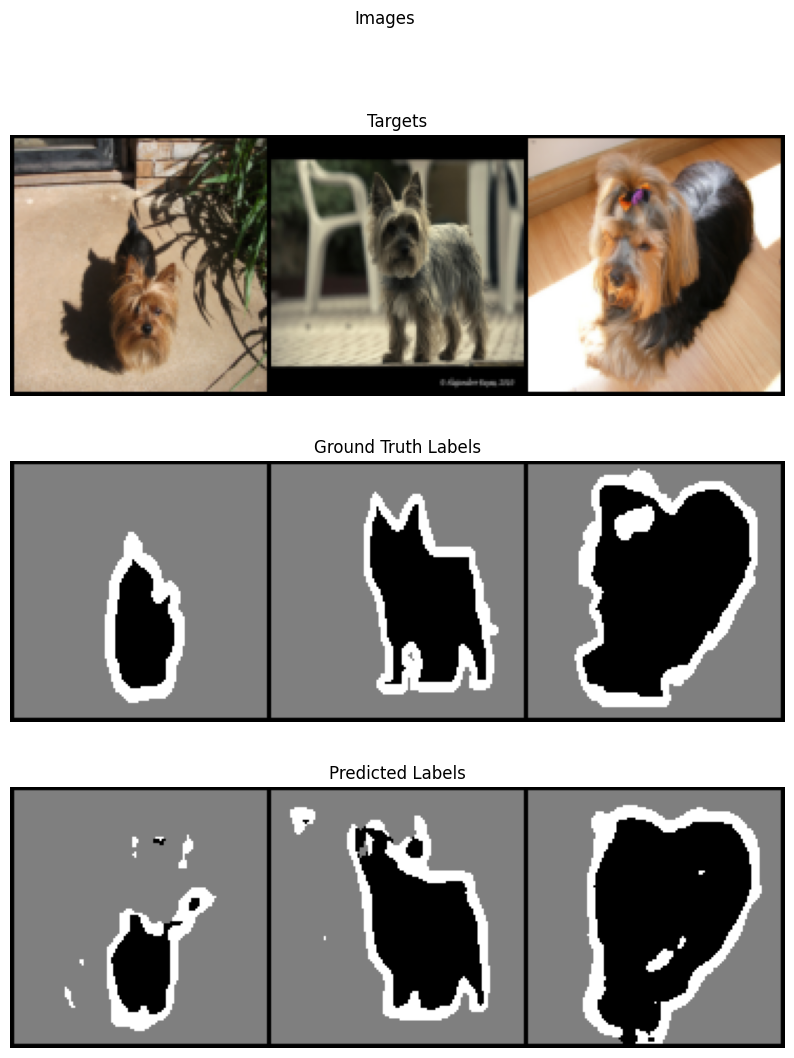

In [35]:
test(model,  test_dataloader, epochs=1)